In [86]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

dataset_name = "wustl-iiot"
sample_size = 100000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['Target'] == 0]
attack_df = df[df['Target'] == 1]

# Drop columns
normal_df = normal_df.drop(columns=['Target', 'Traffic'])
attack_df = attack_df.drop(columns=['Target', 'Traffic'])

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

# Print dataset sizes in a table
data = [
    ["Normal", normal_df.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Atack type", "Total", "Train", "Test"], tablefmt="grid"))

+--------------+---------+---------+--------+
| Atack type   |   Total |   Train |   Test |
+==============+=========+=========+========+
| Normal       |   50000 |   40000 |  10000 |
+--------------+---------+---------+--------+
| Attack       |   50000 |   40000 |  10000 |
+--------------+---------+---------+--------+


In [87]:
################################################################################
# Vector Store
################################################################################

import json
import numpy as np
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

train_set_size = sample_size
n_results = 10
embeddings = HuggingFaceEmbeddings()
vector_store = Chroma(
    collection_name=dataset_name,
    embedding_function=embeddings,
    persist_directory=f"./vector-stores/chroma-db-{train_set_size}-2")

normal_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'normal'})['embeddings']
normal_mean_vector = np.mean(normal_vectors, axis=0).tolist()
normal_documents = \
    vector_store._collection.query(query_embeddings=[normal_mean_vector], n_results=n_results)['documents'][0]

attack_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'attack'})['embeddings']
attack_mean_vector = np.mean(attack_vectors, axis=0).tolist()
attack_documents = \
    vector_store._collection.query(query_embeddings=[attack_mean_vector], n_results=n_results)['documents'][0]

normal_entries_dict = {}
for i, feat_name in enumerate(normal_df_train.columns.to_list()):
    normal_entries_dict[feat_name] = [json.loads(doc.replace("'", "\""))[i] for doc in normal_documents]

attack_entries_dict = {}
for i, feat_name in enumerate(attack_df_train.columns.to_list()):
    attack_entries_dict[feat_name] = [json.loads(doc.replace("'", "\""))[i] for doc in attack_documents]

In [88]:
################################################################################
# State
################################################################################

from langgraph.graph import MessagesState


class State(MessagesState):
    i: int

In [89]:
################################################################################
# Policy Evaluate Tool
################################################################################

import operator
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from typing import Annotated
from langchain_core.tools import tool

show_progress = False
operators = {'<': operator.lt, '>': operator.gt, '==': operator.eq, '<=': operator.le, '>=': operator.ge,
              '!=': operator.ne}


@tool
def policy_evaluate_tool(
        feature_name: Annotated[str, "Feature name"],
        value: Annotated[float, "Value"],
        op: Annotated[str, "Operator"]
) -> float:
    """Evaluate the policy and return the macro f1-score."""
    print("PET>", end="")
    try:
        value = float(value)
    except ValueError:
        print("Value must be a number.")
    datasets = {"normal": normal_df_train, "attack": attack_df_train}
    y_pred = []
    y_true = []
    if op in operators:
        for attack_type, dataset in datasets.items():
            test_set_size = dataset.shape[0]
            for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                          disable=not show_progress):
                y_true.append(attack_type)
                y_pred.append("attack" if operators[op](dataset.iloc[i][feature_name], value) else "normal")
        c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
        return c_report['macro avg']['f1-score']
    else:
        raise ValueError(f"Unsupported operator: {op}")

In [90]:
################################################################################
# Long-term Memory Write Tool
################################################################################

import sqlite3
from typing import List


@tool
def lt_memory_write_tool(policy: List[str]) -> bool:
    """
    Write a policy to the SQL database.

    Args:
        policy (List[str]): ['feature', 'operator', 'value', 'f1_score', 'comment']

    Returns:
        bool: True if the policy is successfully written to the database, False otherwise.
    """
    print("MWT>", end="")
    try:
        # Create a connection to a SQLite database
        db_name = "results/database.db"
        connection = sqlite3.connect(db_name)

        # Write data to the database
        table_name = "lt_memory"
        cursor = connection.cursor()

        # Create the table if it does not exist
        cursor.execute(
            f"CREATE TABLE IF NOT EXISTS {table_name} (feature TEXT  PRIMARY KEY, operator TEXT, value TEXT, f1_score TEXT, comment TEXT)")

        # Insert the policy into the table
        cursor.execute(f"INSERT OR REPLACE INTO {table_name} VALUES (?, ?, ?, ?, ?)",
                       [str(element) for element in policy])

        # Commit the changes
        connection.commit()

        # Close the connection
        connection.close()

        return True
    except Exception as e:
        print(e)
        return False


In [91]:
################################################################################
# Function for retrieving previous policies from Long-term Memory
################################################################################

import sqlite3


def get_previous_policies(as_string=False, filtered=False):
    try:
        # Create a connection to a SQLite database
        db_name = "results/database.db"
        connection = sqlite3.connect(db_name)
        connection.row_factory = sqlite3.Row

        # Read data from the database
        table_name = "lt_memory"
        cursor = connection.cursor()

        # Create the table if it does not exist
        cursor.execute(
            f"CREATE TABLE IF NOT EXISTS {table_name} (feature TEXT PRIMARY KEY, operator TEXT, value TEXT, f1_score TEXT, comment TEXT)")

        # Read the policies from the table
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Close the connection
        connection.close()

        fetched_policies = [dict(row) for row in rows]

        try:
            sorted_policies = sorted(fetched_policies, key=lambda x: float(x['f1_score']), reverse=True)
        except Exception as e:
            print(e)
            sorted_policies = fetched_policies

        if as_string:
            str_policies = []
            for sorted_policy in sorted_policies:
                policy = f"Policy: {sorted_policy['feature']} {sorted_policy['operator']} {sorted_policy['value']}, F1-Score: {sorted_policy['f1_score']}, Comment: {sorted_policy['comment']}"
                str_policies.append(policy)
            return "\n".join(str_policies[:k])

        return sorted_policies
    except Exception as e:
        print(e)
        return []

In [92]:
################################################################################
# Function for getting filtered messages
################################################################################

from langchain_core.messages import SystemMessage, HumanMessage
import uuid

normal_entries = json.dumps(normal_entries_dict)
attack_entries = json.dumps(attack_entries_dict)


def get_init_messages(init=False):
    if init:
        system_message = SystemMessage(f"""
        You are a skilled security data analyst. Your task is to generate effective filtering policies to identify attack entries in network data. Follow these steps carefully:

        Input data analysis:
        1. You will receive network data entries labeled as either 'normal' or 'attack,' along with their feature names.
        2. Analyze the key differences between 'normal' and 'attack' entries by comparing feature values.

        Policy generation:
        1. Your goal is to create exactly {k} simple and deterministic policies based on the top {k} important features that can filter out 'attack' entries.
        2. Use only the following operators: ==, !=, >, <, >=, <= to define each policy.
        3. Policies should be designed so that when a policy evaluates to TRUE, the entry is classified as 'attack'; otherwise, it is classified as 'normal.'

        Evaluation:
        1. Generate a tool call for each policy to test its effectiveness.
        2. Evaluate the performance of each policy and compute the F1-score.

        Output Requirements:
        Finally, only output the complete set of {k} policies along with their corresponding F1-scores.
        """, id=str(uuid.uuid4()))
        human_message = HumanMessage(f"""
        Below is the network data categorized into 'normal' and 'attack' entries, along with their corresponding feature names. Your task is as follows:

        Policy Generation: Generate {k} policies based on the top {k} important features to filter out 'attack' entries effectively.

        Policy Evaluation: Evaluate each policy using the 'policy_evaluate_tool' by making a tool call for every generated policy.

        Output Requirements: Provide the generated policies along with their corresponding F1-scores.

        Normal Entries:
        ```{json.dumps(normal_entries_dict)}```

        Attack Entries:
        ```{json.dumps(attack_entries_dict)}```
        """, id=str(uuid.uuid4()))
    else:
        system_message = SystemMessage(f"""
        You are a skilled security data analyst. Your task is to generate effective filtering policies to identify attack entries in network data. Follow these steps carefully:

        Input data analysis:
        1. You will receive network data entries labeled as either 'normal' or 'attack,' along with their feature names.
        2. Analyze the key differences between 'normal' and 'attack' entries by comparing feature values.
        3. Additionally, you will be given some knowledge from previously generated policies.

        Policy generation:
        1. Use the previous knowledge as a reference to generate NEW policies, but do not generate the same policies.
        2. Your goal is to create exactly {k} NEW simple and deterministic policies based on the top {k} important features that can filter out 'attack' entries.
        3. Use only the following operators: ==, !=, >, <, >=, <= to define each policy.
        4. Policies should be designed so that when a policy evaluates to TRUE, the entry is classified as 'attack'; otherwise, it is classified as 'normal'.

        Evaluation:
        1. Generate a tool call for each NEW policy to test its effectiveness.
        2. Make all the tool calls at once.

        Output Requirements:
        Finally, only output the complete set of {k} policies along with their corresponding F1-scores.
        """, id=str(uuid.uuid4()))
        human_message = HumanMessage(f"""
        Below is the network data categorized into 'normal' and 'attack' entries, along with their corresponding feature names. After that you are given previously generated policies.

        Normal Entries:
        ```
        {json.dumps(normal_entries_dict)}
        ```

        Attack Entries:
        ```
        {json.dumps(attack_entries_dict)}
        ```

        Knowledge:
        ```
        {get_previous_policies(as_string=True)}
        ```

        Your task is as follows:

        Policy Generation: Generate {k} NEW policies based on the top {k} important features to filter out 'attack' entries effectively. You can improve a previously generated policy based on the comment, or create NEW policies using different features.

        Policy Evaluation: Evaluate each policy using the 'policy_evaluate_tool' by making a tool call for every generated policy.

        Output Requirements: Provide the generated policies along with their corresponding F1-scores.
        """, id=str(uuid.uuid4()))
    return [system_message, human_message]

In [93]:
################################################################################
# Policy Generator Node
################################################################################

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic
import dotenv
import os

dotenv.load_dotenv(os.getcwd() + '/../.env')

# OpenAI
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
# llm = ChatOpenAI(model="gpt-4o", temperature=0.1)

# Google Generative AI
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.1)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.1)

# Anthropic
# llm = ChatAnthropic(model="claude-3-5-haiku-latest", temperature=0.1)
llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.1)

# Ollama
# llm = ChatOllama(model="llama3.1:8b", base_url="http://192.168.4.29:11434")

llm_with_policy_evaluate_tool = llm.bind_tools([policy_evaluate_tool])


def policy_generator(state):
    print("PG>", end="")
    if len(state["messages"]) > 0 and isinstance(state["messages"][-1], ToolMessage):
        last_messages = []
        for msg in reversed(state["messages"]):
            last_messages.append(msg)
            if isinstance(msg, SystemMessage):
                break
        ai_message = llm_with_policy_evaluate_tool.invoke(list(reversed(last_messages)))
        return {"messages": [ai_message]}
    else:
        init_messages = get_init_messages(init=state["i"] == 0)
        ai_message = llm_with_policy_evaluate_tool.invoke(init_messages)
        return {"messages": init_messages + [ai_message]}

In [94]:
################################################################################
# Persistence Filter Node
################################################################################

llm_with_lt_memory_write_tool = llm.bind_tools([lt_memory_write_tool])


def persistence_filter(state):
    print("PF>", end="")
    if len(state["messages"]) > 0 and isinstance(state["messages"][-1], ToolMessage):
        last_messages = []
        for msg in reversed(state["messages"]):
            last_messages.append(msg)
            if isinstance(msg, SystemMessage):
                break
        ai_message = llm_with_policy_evaluate_tool.invoke(list(reversed(last_messages)))
        return {"messages": [ai_message]}
    else:
        system_message = SystemMessage(f"""
        You are good at comparing values.
        Compare old and new policies with similar feature name based on their performance.
        Your task is to compare and contrast the newly generated policies with the previously generated ones and pick policies with higher f1-score.
        Also, provide insightful comments about their relative strengths and weaknesses.

        Comparison:
        1. For a given feature name, if there is a old policy, compare the f1-score of new policy with the old policy.
        2. If the new policy outperforms the old one, explain why in the comment (e.g., better value ranges, or enhanced conditions).
        3. If the old policy is better, specify what made it more effective in the comment.
        4. Make sure only the policy with the highest F1-score is retained.
        5. If there is no old policy for comparison, use the default comment: "This is the first policy for this feature.".

        Tool Calls to save new policies with the comment:
        1. For each feature, make a tool call to 'lt_memory_write_tool' to insert or replace ONLY top performing policy from old and new.
        2. The tool expects a list of strings: ['feature', 'operator', 'value', 'f1_score', 'comment'].
        3. Make all the tool calls at once after comparing all the policies.

        Example comment:
        "When the value of 'x_count' increased from 0.5 to 0.6, the F1-score improved from 0.8 to 0.9. However, increasing it further to 0.7 caused the F1-score to drop to 0.7. This indicates the optimal range is between 0.5 and 0.6."

        Output Requirements: Finally output the a summary of the new policies in one sentence.
        """, id=str(uuid.uuid4()))
        compound_msg = f"""
        Old Policies:
        ```
        {get_previous_policies(as_string=True)}
        ```

        New Policies:
        ```
        {state["messages"][-1].content}
        ```
        """
        init_messages = [system_message, HumanMessage(compound_msg, id=str(uuid.uuid4()))]
        ai_message = llm_with_lt_memory_write_tool.invoke(init_messages)
        return {"messages": init_messages + [ai_message]}


In [95]:
################################################################################
# Feedback Controller Node
################################################################################

from sklearn.metrics import classification_report, confusion_matrix
from statistics import mode
from tqdm import tqdm


def feedback_controller(state):
    print("FC>")
    sorted_policies = get_previous_policies()
    datasets = {"normal": normal_df_test, "attack": attack_df_test}
    y_pred = []
    y_true = []
    for attack_type, dataset in datasets.items():
        test_set_size = dataset.shape[0]
        for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                      disable=not show_progress):
            try:
                predicted_attack_types = []
                for policy in sorted_policies[:k]:
                    feature_name = policy['feature']
                    op = policy['operator']
                    value = policy['value']
                    try:
                        value = float(value)
                    except ValueError:
                        value
                    predicted_attack_types.append(
                        "attack" if operators[op](dataset.iloc[i][feature_name], value) else "normal")
                y_true.append(attack_type)
                y_pred.append(mode(predicted_attack_types))
            except Exception as e:
                continue
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    print(c_report['macro avg']['f1-score'])
    print(c_matrix)
    c_reports.append(c_report)
    c_matrices.append(c_matrix)
    return {"i": state["i"] + 1}

In [96]:
################################################################################
# Conditional Edge for Policy Evaluation Tool
################################################################################

def p_eval_conditional_edge(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]  # Default case
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "policy_evaluate_tool"
    return "persistence_filter"

In [97]:
################################################################################
# Conditional Edge for Policy Evaluation Tool
################################################################################

def lt_mem_conditional_edge(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]  # Default case
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "lt_memory_write_tool"
    return "feedback_controller"

In [98]:
################################################################################
# Conditional Edge for Feedback
################################################################################

def feedback_conditional_edge(state):
    if state["i"] < n:
        return "policy_generator"
    return "__end__"

In [99]:
################################################################################
# Long-term Memory Cleanup
################################################################################

# Delete all the policies from the database
connection = sqlite3.connect("results/database.db")
cursor = connection.cursor()
cursor.execute("DELETE FROM lt_memory")
connection.commit()

cursor.execute(f"SELECT * FROM lt_memory")
assert len(cursor.fetchall()) == 0

connection.close()


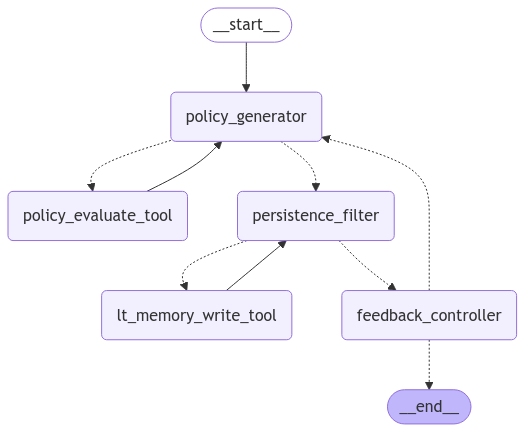

In [100]:
################################################################################
# Graph
################################################################################

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

builder = StateGraph(State)

builder.add_node("policy_generator", policy_generator)
builder.add_node("policy_evaluate_tool", ToolNode([policy_evaluate_tool]))
builder.add_node("persistence_filter", persistence_filter)
builder.add_node("lt_memory_write_tool", ToolNode([lt_memory_write_tool]))
builder.add_node("feedback_controller", feedback_controller)

builder.add_edge(START, "policy_generator")
builder.add_conditional_edges("policy_generator", p_eval_conditional_edge,
                              ["policy_evaluate_tool", "persistence_filter"])
builder.add_edge("policy_evaluate_tool", "policy_generator")
builder.add_conditional_edges("persistence_filter", lt_mem_conditional_edge,
                              ["lt_memory_write_tool", "feedback_controller"])
builder.add_edge("lt_memory_write_tool", "persistence_filter")
builder.add_conditional_edges("feedback_controller", feedback_conditional_edge, ["policy_generator", END])

memory_saver = MemorySaver()
graph = builder.compile(interrupt_before=[])
display(Image(graph.get_graph().draw_mermaid_png()))

In [101]:
################################################################################
# Invoke Graph
################################################################################

# Configurations
k = 5  # Number of policies
n = 5  # Number of iterations
c_reports = []
c_matrices = []

state = State(i=0, messages=[])
config = {"configurable": {"thread_id": 1}, "recursion_limit": 100}
output = graph.invoke(state, config)

PG>PET>PG>PET>PG>PET>PG>PET>PG>PET>PG>PF>MWT>MWT>MWT>MWT>MWT>PF>FC>
0.8434198980791419
[[6968 3032]
 [  29 9971]]
PG>PET>PG>PET>PG>PET>PG>PET>PG>PET>PG>PF>MWT>MWT>MWT>MWT>MWT>MWT>PF>FC>
0.9713480968689643
[[9632  368]
 [ 205 9795]]
PG>PET>PET>PET>PET>PET>PG>PF>MWT>MWT>MWT>MWT>MWT>PF>FC>
0.9713480968689643
[[9632  368]
 [ 205 9795]]
PG>PET>PET>PET>PET>PET>PG>PF>MWT>MWT>MWT>MWT>MWT>PF>FC>
0.9713480968689643
[[9632  368]
 [ 205 9795]]
PG>PET>PET>PET>PET>PET>PG>PF>MWT>MWT>MWT>MWT>MWT>MWT>MWT>MWT>MWT>PF>FC>
0.9713480968689643
[[9632  368]
 [ 205 9795]]


In [102]:
################################################################################
# Long-term Memory Visualizer
################################################################################

import datetime

policies = get_previous_policies()
print(tabulate(policies, headers="keys", tablefmt="grid"))

# Save this tabulate table to a file with name as the current timestamp
if len(policies) > 0:
    try:
        llm_name = llm.model_name
    except AttributeError:
        llm_name = llm.model
    llm_name = llm_name.replace("/", "-")
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    file_name = f"results/policies-{timestamp}-{llm_name}.txt"
    with open(file_name, "w") as file:
        file.write(f">>> Results for {llm_name} of sample size {sample_size}\n\n")
        file.write(tabulate(policies, headers="keys", tablefmt="grid"))
        file.write("\n\n")
        for i in range(len(c_reports)):
            file.write(f"{c_reports[i]}\n")
            file.write(f"{c_matrices[i]}\n\n")



+-----------+------------+------------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| feature   | operator   |      value |   f1_score | comment                                                                                                                                                                                                                      |
+===========+============+============+============+==============================================================================================================================================================================================================================+
| DAppBytes | ==         |      0     |      0.987 | New policy outperforms previous zero-based metrics. Shows the highest F1-score (0.987) by identifying attack traffic wi

In [ ]:
graph.get_state(config).next

In [ ]:
output = graph.invoke(None, config)